# Bidding Strategy Optimization

This question is open-ended as we want to assess your ability to attack a new problem. The focus of the quant team is to make automated trading decisions under high certainty. In this exercise, you are expected to learn a day ahead to real time price arbitrage trading strategy.

We are providing you with a historical timeseries of 5 engineered features $X \in \mathbb{R}^{n,5}$, and the corresponding day ahead prices $da \in \mathbb{R}^{n, 7}$ and real time prices $rt \in \mathbb{R}^{n, 7}$ for 7 trading hubs. In addition to the explanatory power of the features, there are autoregressive features that can be derived from the timeseries. You may wish to take this approach, but any autoregressive features you wish to use need a 2 day lag to match the time horizons of the market settlements.

The goal is to learn a function $f(\textbf{x})$ that returns a vector of trading bid volumes $\textbf{v}^l \in \mathbb{R}^{7}$,
a vector of trading offer volumes $\textbf{v}^s \in \mathbb{R}^{7}$, and corresponding bid prices $\textbf{p}^l \in \mathbb{R}^{7}$  and offer prices $\textbf{p}^s \in \mathbb{R}^{7}$ that maximizes the trading profit subject to a worst loss risk constraint, which for this exercise is 1000 dollars. The l, and s refer to whether the trade is (l)ong or (s)hort the real time market. Note that the problem is find the optimal result on the out of sample data (i>n).

Formally, the problem becomes:

$\max{\sum_{i=n}^\infty} hourly\_result(\textbf{v}_i^l, \textbf{p}_i^l, \textbf{v}_i^s, \textbf{p}_i^s, 
\textbf{da}_i, \textbf{rt}_i)$

subject to 

$\min(hourly\_result(\textbf{v}_i^l, \textbf{p}_i^l, \textbf{v}_i^s, \textbf{p}_i^s, 
\textbf{da}_i, \textbf{rt}_i)) > -1000$ for all i

where $\textbf{p}^l, \textbf{v}^l, \textbf{p}^s, \textbf{v}^s=f(\textbf{x})$,


$hourly\_result(\textbf{v}^l, \textbf{p}^l, \textbf{v}^s, \textbf{p}^s, 
\textbf{da}, \textbf{rt})=\sum_{j=1}^7(v_{j}^l (p^{l}_{j}\ge da_{j})(rt_{j}-da_{j})) + (v_{j}^s (p_{j}^s\le da_{j})(da_{j}-rt_{j}))$,

$v_{ij}^l>=0$  for all  i,j,

$v_{ij}^s>=0$ for all  i,j,

$p_{ij}^l < p_{ij}^s$ for all  i,j,

$i$ is the hourly index,

$j$ is the trading hub index.

This is a non-linear optimization problem where the variables are drawn from an unknown multivariate non-stationary distribution. There is no standard way of handling this problem, so we are excited to see how you reach a result to an unsolvable problem, and the measures you take to prevent overfitting the data. We have split the data into a training set and a validation set, but are holding back a test set that will be used to compare out of sample results with other candidates.


## Dataset

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
data = pd.read_csv("Question2.csv", index_col=0, header=[0,1], parse_dates=True)

In [2]:
da = data["da"]
rt = data["rt"]
X = data["X"]

# example of prices with a two day lag if you wish to use timeseries as features (ie RNN, CNN, ARIMA, etc...)
shifted_da = da.shift(freq="48H")
shifted_rt = rt.shift(freq="48H")

split = datetime(2020,8,1)

X_train = X.loc[:split]
X_validate = X.loc[split:]

da_train = da.loc[:split]
da_validate = da.loc[split:]

rt_train = rt.loc[:split]
rt_validate = rt.loc[split:]

##  Implementation
This is a sample implementation so you can see the functions and data shapes. There is a naive implementation to scaffold the problem. The result is terrible and violates the constraint. Reimplement the solution however you wish.

In [3]:
def hourly_results(v_plus, bid_price, v_neg, offer_price, da, rt):
    
    return (v_plus * (da <= bid_price) * (rt - da)) + (v_neg * (offer_price < da) * (da - rt))

In [4]:
def worst_loss(results):
    
    return min(results.sum(axis=1))

In [5]:
class Model:
    """
    Trains a model from a feature matrix. 
    This is a placeholder that bids random volume around a static historic mean.
    Reimpliment this class using a machine learning/optimization process where you can demonstrate
    your knowledge and creativity.
    """
    
    def train(self, X, da, rt):
        """
        Param X: A matrix of features.
        Param da: A matrix of market day ahead prices.
        param rt: A matrix of market real time prices.

        """
        
        self.bid_price = da.mean(axis=0).values - 1.0 # bu a dollar below the mean
        self.offer_price = da.mean(axis=0).values + 1.0 # sell a dollar above the mean
        np.random.seed(1)
        self.v_long = np.random.randn(*self.bid_price.shape) # random bid volume
        self.v_short = np.random.randn(*self.bid_price.shape) # random offer volume
        
        return self
        
    def predict(self, X):
        
        return (np.tile(self.bid_price, (X.shape[0], 1)), np.tile(self.v_long, (X.shape[0], 1)),
                np.tile(self.offer_price, (X.shape[0], 1)), np.tile(self.v_short, (X.shape[0], 1)))

-1440.3381595172373


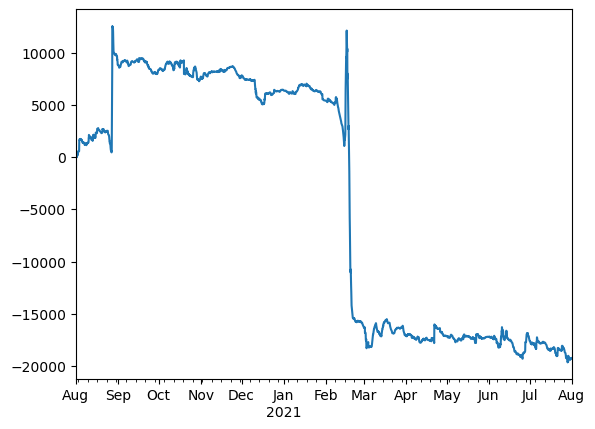

In [6]:
obj = Model()
obj.train(X_train, da, rt)
bids, v_long, offers, v_short = obj.predict(X_validate)

results = hourly_results(v_long, bids, v_short, offers, da_validate, rt_validate)
pnl = results.sum(axis=1).cumsum().plot()
constraint = worst_loss(results)
print(constraint)

## Results

We will run this on the test data we have held back and will discuss results if you are selected for a final technical interview.

In [14]:
# X_test, da_test, rt_test = read_test_data() # held back by CWP
# obj.fit(X, da, rt)
# bids, v_long, offers, v_short = obj.predict(X_test)
# result = daily_result( v_long, bids, v_short, offers)